# **1. Introduction** <a class="anchor" id="1"></a>

## **1.2. Import packages**

In [1]:
# Remember: library imports are ALWAYS at the top of the script, no exceptions!
import math
import sqlite3
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from math import ceil
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from pandas_profiling import ProfileReport
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.decomposition import PCA
# Feature selection
from sklearn.feature_selection import VarianceThreshold

from collections import defaultdict
from sklearn.metrics.pairwise import euclidean_distances

from sklearn import random_projection

from scipy.cluster.hierarchy import dendrogram


## **1.3. Import data**

In [2]:
data = pd.read_csv('data/donors.csv',index_col=0, low_memory=False)
print("The data set has total %d records and %d features" %data.shape)

The data set has total 95412 records and 475 features


# **2. Pre-processing data:** <a class="anchor" id="1"></a>

After conducting **Exploratory Data Analysis (Appendix 1)** for 475 features of the original data set, we have listed out the most significant features that we consider to be important for the clustering task.  
Thus, from now, we will continue with these selected features:

In [3]:
# Import the database we create for selecting the features:
features_list = pd.read_csv('Selected_Features.csv',index_col=0)
features_list.head()

,FeaturesName,Description,Category,SubCategory,Selected
Index,,,,,
1,ODATEDW,Origin Date. Date of donor's first gift,Characteristics,NaN,x
2,OSOURCE,Origin Source,Characteristics,NaN,x
3,TCODE,Donor title code,Characteristics,NaN,x
4,STATE,State abbreviation (a nominal/symbolic field),Characteristics,NaN,x
5,ZIP,Zipcode (a nominal/symbolic field),Characteristics,NaN,x


In [4]:
# Get the selected features
selected_feats = features_list[features_list['Selected'] == 'x']['FeaturesName']
df = data[selected_feats].copy()
df.dtypes

ODATEDW     object
OSOURCE     object
TCODE        int64
STATE       object
ZIP         object
             ...  
RFA_2A      object
MDMAUD_R    object
MDMAUD_F    object
MDMAUD_A    object
GEOCODE2    object
Length: 177, dtype: object

## **Feature engineering:** <a class="anchor" id="1"></a>


### **2.1. Getting the Age of every donor:** <a class="anchor" id="1"></a>

We notice that there is one feature called DOB - Day of Birth of the donors, so we thought it would we useful to generate the age of the donors as one feature. The age will be calculate using the current time (2020)

In [5]:
df['DOB'].head()

0    1957-12-01
1    1972-02-01
2           NaN
3    1948-01-01
4    1940-01-01
Name: DOB, dtype: object

In [6]:
#converting the DOB column to datetime type
parsed_dates = pd.to_datetime(df.DOB, format='%Y-%m-%d' , errors='coerce') #errors='coerce' meant to return NaN in case of exception
df['DOB'] = parsed_dates
# Getting the age of every donor today
df['AGE'] = ((dt.datetime.today() - df['DOB']).dt.days/365).floordiv(other=1).astype('int',errors='ignore')

# Append new features to the feature list
feats = pd.DataFrame([['AGE', "Age of the donor","Characteristics","","x" ]],
                    columns=features_list.columns)
features_list= features_list.append(feats,ignore_index=True)

# Now, drop de DOB column as it is no longer useful
df.drop('DOB',inplace=True,axis = 1)

<AxesSubplot:>

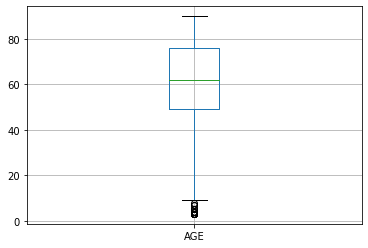

In [7]:
# Check for the box plot and distribution
df.boxplot(['AGE'])
# Here we can see that we have outliers, we will access this in the up coming session

### **2.2. Converting binary features:** <a class="anchor" id="1"></a>

There are features containing binary information but they are not in the right data type for processing, so we convert them to binary type

In [8]:
df.loc[:, 'COLLECT1':'PLATES'].head()

,COLLECT1,VETERANS,BIBLE,CATLG,HOMEE,PETS,CDPLAY,STEREO,PCOWNERS,PHOTO,CRAFTS,FISHER,GARDENIN,BOATS,WALKER,KIDSTUFF,CARDS,PLATES
0,,,,,,,,,,,,,,,,,,
1,,,,,,,,,,,,,,,,,,
2,,,,,,,,,,,,,,,,,,
3,,,,,,,,,,,,,,,,,,
4,,,Y,Y,,,,Y,,,Y,,Y,,Y,,Y,


In [9]:
#Replace the values for booleans
df.loc[:, 'COLLECT1':'PLATES'] = df.loc[:, 'COLLECT1':'PLATES'].replace(' ',0)
df.loc[:, 'COLLECT1':'PLATES'] = df.loc[:, 'COLLECT1':'PLATES'].replace('Y',1)
df.loc[:, 'COLLECT1':'PLATES'].head()

,COLLECT1,VETERANS,BIBLE,CATLG,HOMEE,PETS,CDPLAY,STEREO,PCOWNERS,PHOTO,CRAFTS,FISHER,GARDENIN,BOATS,WALKER,KIDSTUFF,CARDS,PLATES
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,1,1,0,0,0,1,0,0,1,0,1,0,1,0,1,0


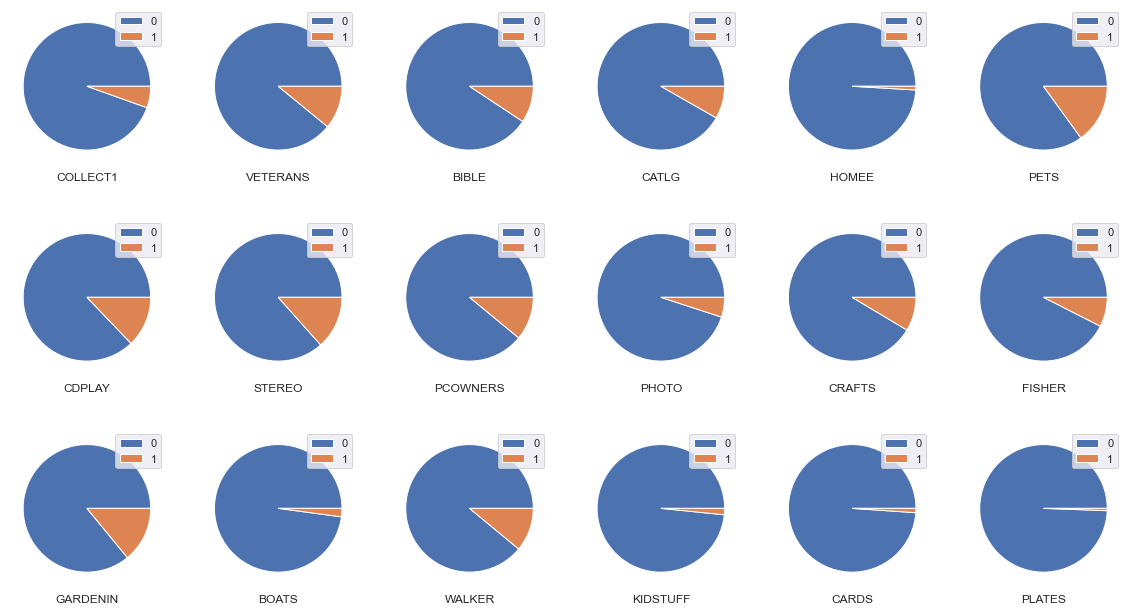

In [10]:
# Plot the result
plotdf = df.loc[:, 'COLLECT1':'PLATES'].apply(pd.value_counts)
#plot pie charts for all the interests
sns.set()
fig, axes = plt.subplots(3, ceil(len(plotdf.columns.to_list()) / 3), figsize=(20,11))
for ax, feat in zip(axes.flatten(), plotdf.columns.to_list()):
    ax.pie(plotdf[feat])
    ax.set_title(feat, y=-0.13)
    ax.legend(plotdf.index)
plt.show() 

### **2.3. Generate RFA status of the each donor before they are considered to be Lapsed Donor:** <a class="anchor" id="1"></a>

Because all the donors which is investigated in this dataset is all Lapsed Donors as the date of the lasted promotion, so we will not able to undestand the 'Recency' charateristics if we only consider the most recent code of the donor (all 'Lapsed').  
Therefore, we thought it would be interesting if we get the most recent type of code of each donor before they are considered to become Lapsed Donors

We will consider the data in features **Donor's RFA status as of XXXX promotion date (XXXX is from 'RFA_3'to 'RFA_24')**

In [11]:
# Replace the blank values with NaN value
df.loc[:,'RFA_3':'RFA_24'] = df.loc[:,'RFA_3':'RFA_24'].replace({' ' : np.NaN})
# Find the second most recent type of a donor by the left-most available values from RFA_3 to RFA_24
df['RFA_USEDTO'] = df.loc[:,'RFA_3':'RFA_24'].fillna(method = 'bfill',axis = 1)['RFA_3']
# Renerate R, F, A features
df['RFA_USEDTO_R'] = df['RFA_USEDTO'].apply(lambda x: str(x)[0])
df['RFA_USEDTO_F'] = df['RFA_USEDTO'].apply(lambda x: str(x)[1])
df['RFA_USEDTO_A'] = df['RFA_USEDTO'].apply(lambda x: str(x)[2])

# Add to the selected features list
feats = pd.DataFrame([['RFA_USEDTO_R', "Recency code of the previous status of the donor","Promotion and Gift","","x" ],
                    ['RFA_USEDTO_F', "Frequency code of the previous status of the donor","Promotion and Gift","","x"], 
                    ['RFA_USEDTO_F', "Amount code of the previous status of the donor","Promotion and Gift","","x"]],
                    columns=features_list.columns)
features_list= features_list.append(feats,ignore_index=True)

# Now drop the features that is no longer useful
df.drop(labels='RFA_USEDTO',axis=1,inplace = True, errors='ignore')
# Check for the result
df.loc[:,'RFA_USEDTO_R':'RFA_USEDTO_A'].head()

,RFA_USEDTO_R,RFA_USEDTO_F,RFA_USEDTO_A
0,S,4,E
1,A,2,G
2,S,4,E
3,S,4,E
4,A,2,F


In [12]:
# Drop the RFA status of donor as they are no longer useful
df.drop(labels=df.loc[:,'RFA_3':'RFA_24'].columns,axis=1,inplace=True,errors='ignore')
df.head()

,ODATEDW,OSOURCE,TCODE,STATE,ZIP,MAILCODE,MDMAUD,DOMAIN,HOMEOWNR,CHILD03,...,RFA_2F,RFA_2A,MDMAUD_R,MDMAUD_F,MDMAUD_A,GEOCODE2,AGE,RFA_USEDTO_R,RFA_USEDTO_F,RFA_USEDTO_A
0,2009-01-01,GRI,0,IL,61081,,XXXX,T2,,,...,4,E,X,X,X,C,63.0,S,4,E
1,2014-01-01,BOA,1,CA,91326,,XXXX,S1,H,,...,2,G,X,X,X,A,48.0,A,2,G
2,2010-01-01,AMH,1,NC,27017,,XXXX,R2,U,,...,4,E,X,X,X,C,NaN,S,4,E
3,2007-01-01,BRY,0,CA,95953,,XXXX,R2,U,,...,4,E,X,X,X,C,72.0,S,4,E
4,2006-01-01,,0,FL,33176,,XXXX,S2,H,,...,2,F,X,X,X,A,80.0,A,2,F


## Now we have 158 features

In [13]:
selected_feats = features_list.loc[features_list['FeaturesName'].isin(df.columns),:]
selected_feats.head()

,FeaturesName,Description,Category,SubCategory,Selected
0,ODATEDW,Origin Date. Date of donor's first gift,Characteristics,NaN,x
1,OSOURCE,Origin Source,Characteristics,NaN,x
2,TCODE,Donor title code,Characteristics,NaN,x
3,STATE,State abbreviation (a nominal/symbolic field),Characteristics,NaN,x
4,ZIP,Zipcode (a nominal/symbolic field),Characteristics,NaN,x
...,...,...,...,...,...
474,GEOCODE2,County Size Code,Characteristics,NaN,x
475,AGE,Age of the donor,Characteristics,,x
476,RFA_USEDTO_R,Recency code of the previous status of the donor,Promotion and Gift,,x
477,RFA_USEDTO_F,Frequency code of the previous status of the d...,Promotion and Gift,,x


In [18]:
# Summary by category
pd.DataFrame(selected_feats.groupby('Category')['FeaturesName'].count())

,FeaturesName
Category,
Characteristics,23
Interests,19
Mail response,14
Neighborhood,75
Promotion and Gift,27


# **3. Data cleanning:** <a class="anchor" id="1"></a>

You guys can start from here

In [15]:
#find features with correlations greater than 0.9 in order to remove them
limit = 0.90
corr = df.corr()
mask = np.triu(np.ones(corr.shape), k=1).astype(bool)
corr_no_diag = corr.where(mask)
coll = [c for c in corr_no_diag.columns if any(abs(corr_no_diag[c]) > limit)]
coll
#df.drop(coll,axis = 1,inplace=True)

['LFC4', 'NUMPROM', 'CARDGIFT']

In [16]:
#boxplot_func(df)

### Plotting functions

In [17]:
def boxplot_func(df):
    plot_features = df.columns
    #Prepare figure layout
    rows = int(math.ceil(df.shape[1]/8))
    sns.set()
    fig, axes = plt.subplots(nrows = rows, ncols=8, figsize=(16,4*rows))
  
    # Draw the boxplots
    for i in zip(axes.flatten(), plot_features):
        sns.boxplot(data=df.loc[:,i[1]], ax=i[0])      
        i[0].set_title(i[1])
        i[0].set_ylabel("")
        for tick in i[0].get_xticklabels():
            tick.set_rotation(-25)
    
    # Finalize the plot
    plt.subplots_adjust(wspace=2,hspace = 0.5)
    fig.suptitle("Box plots", fontsize=25)
    sns.despine(bottom=True)
    plt.show()
    
def histplot_func(df):
    plot_features = df.columns
    #Prepare figure layout
    rows = int(math.ceil(df.shape[1]/8))
    sns.set()
    fig, axes = plt.subplots(nrows = rows, ncols=8, figsize=(24,2*rows))
       
    # Draw the boxplots
    for i in zip(axes.flatten(), plot_features):
        sns.histplot(data=df.loc[:,i[1]], bins=20,ax=i[0])
        i[0].set_xlabel(i[1])
        i[0].set_ylabel("")
      
    # Finalize the plot
    plt.subplots_adjust(wspace=0.5,hspace = 0.5)
    fig.suptitle("Histograms", fontsize=15)
    sns.despine(bottom=True)
    plt.show()
    
def corrheatmap(dataframe):
    sns.set(style="white")

    # Compute the correlation matrix
    corr = dataframe.corr() #Getting correlation of numerical variables

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool) #Return an array of zeros (Falses) with the same shape and type as a given array
    mask[np.triu_indices_from(mask)] = True #The upper-triangle array is now composed by True values

    # Set up the matplotlib figure
    fig, ax = plt.subplots(figsize=(12, 6))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True) #Make a diverging palette between two HUSL colors. Return a matplotlib colormap object.

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, annot=True,annot_kws={"fontsize":8}, linewidths=.5,vmin = -1, vmax = 1, ax=ax)

    # Layout
    plt.subplots_adjust(top=0.95)
    plt.suptitle("Correlation matrix", fontsize=15)
    plt.yticks(rotation=0)
    # Fixing the bug of partially cut-off bottom and top cells
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values

    plt.show()